In [1]:
from qcompile import comp_utils as utils
from qiskit import *
import numpy as np
from pprint import pprint
import random 
import matplotlib.pyplot as plt

random.seed(1)  # set random seed 1

NameError: name 'S' is not defined

## Introduction / Objective

What is a 'Compiler'?

A compiler is responsible for taking abstract programs and commands (for example code written in Python or C) and converting them into commands that can be executed on the hardware level. A quantum compiler takes an abstract quantum circuit and decomposes it into hardware specific commands. Sadly, I do not have access to a quantum computer on hand. So instead I will be creating a ‘translator’ of sorts. Often times it is physically difficult to implement every type of quantum logic gate on a quantum computer; and certain types of quantum computers have a natural implementation for certain gates (eg. Ising gates on a trapped Ion QC). Thus we need to convert most quantum gates into a smaller set of ‘simple’ basis gates which are physically implemented.  

Our primary goal will be creating a simple translator which takes a quantum circuit made up of the following quantum gates:

I, H, X, Y, Z, RX, RY, RZ, CNOT, CZ 

To create a similar quantum circuit made up of only RX, RZ and CZ gates. 

In an effort to be more transparent with my thought process, I will walk through the core development of the compiler through this notebook.

In [2]:
# Intro to some helper functions (which can be found in comp_utils.py): 

circ = qiskit.QuantumCircuit(3)   # construct a simple 3 qbit circuit 
circ.h(0)
circ.cx(0, 2)
circ.i(1)
circ.z(0)

print(circ)    ## visualize the circuit 

## read_circ .......................................................................................................

gate_lst, num_qbits = utils.read_circ(circ)  # here we use the read_circ helper function to extract the meta data 
print('gate_lst: {}\n'.format(gate_lst))     # the gate_lst is an ordered list of tuples containing info about 
                                             # the gate, the qbits being applied to, and the parameters of the gate 
    
## general_replace .................................................................................................

utils.general_replace(gate_lst, 'Z', [('X', [], [])])  # the general_replace function allows us to manipulate the gate_lst
print('replaced Z: {}\n'.format(gate_lst))             # here I replaced each instance of Z gate with an X gate. 

utils.general_replace(gate_lst, 'I', [])               # we can remove gates by providing an empty list of replacement gates
print('removed I: {}\n'.format(gate_lst))              # here I just removes every instance of 'I'

## write_circ ......................................................................................................

new_circ = utils.write_circ(gate_lst, num_qbits)  # this function takes the gate_lst and creates a qiskit circuit object
print(new_circ)


NameError: name 'qiskit' is not defined

## Understanding the Quantum Gates

The first thing we need to do is understand the mathematical definition of each of our quantum logic gates: 

$ I = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} $ 
$ H = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} $

$ X = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} $ , $ Y = \begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix} $ , $ Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix} $

$ Rx(\theta) = \begin{bmatrix} \cos{\frac{\theta}{2}} & -i\sin{\frac{\theta}{2}} \\ -i\sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}} \end{bmatrix} $ , 
$ Ry(\theta) = \begin{bmatrix} \cos{\frac{\theta}{2}} & -\sin{\frac{\theta}{2}} \\ \sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}} \end{bmatrix} $ , 
$ Rz(\phi) = \begin{bmatrix} e^{\frac{-i\phi}{2}} & 0 \\ 0 & e^{\frac{i\phi}{2}} \end{bmatrix} $

$ CNOT = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix} $ , 
$ Cz = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & -1 \end{bmatrix} $


We observe that each of these matricies is an orthonormal matrix with a trivial kernel. Doing a little bit of algebra, we can also verify that each of these matricies is infact unitary.These properties lend to a very nice geometrical interpretation of the matricies as rotation along the bloch sphere, we will leverage this geometrical interpretation when building the compiler.

We begin by making the following association which connects the complex coefficients of our qbit to a point in R3: 

$$ \vec{r} = \begin{bmatrix} \sin{\theta}\cos{\phi} \\ \sin{\theta}\sin{\phi} \\ \cos{\theta} \end{bmatrix} \Longrightarrow
   \vec{c} = \begin{bmatrix} \cos{\frac{\theta}{2}} \\ e^{i\phi}\sin{\frac{\theta}{2}} \end{bmatrix} $$


One can show (with a little bit of algebra) that the matricies $Rx$ , $Ry$ and $Rz$ correspond to rotations along the X-axis by $\theta$, Y-axis by $\theta$ and Z-axis by $\phi$ respectively. 

The first problem we will tackle will be trying to construct the $Ry(\lambda)$ through combinations of the $Rx(\theta)$ and $Rz(\phi)$. let $R_{3x}$ , $R_{3y}$ and $R_{3z}$ denote the 3D rotation matricies. 

$$ R_{3x}(\theta) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & \cos{\theta} & -\sin{\theta} \\ 0 & \sin{\theta} & \cos{\theta} \end{bmatrix} $$

$$ R_{3y}(\lambda) = \begin{bmatrix} \cos{\lambda} & 0 & \sin{\lambda} \\ 0 & 1 & 0 \\ -\sin{\lambda} & 0 & \cos{\lambda} \end{bmatrix} $$

$$ R_{3z}(\phi) = \begin{bmatrix} \cos{\phi} & -\sin{\phi} & 0 \\ \sin{\phi} & \cos{\phi} & 0 \\ 0 & 0 & 1 \end{bmatrix} $$

In order to describe an arbitrary rotation by angle $\lambda$ around the y-axis, we realize we need to rotate around the x-axis by some angle $\theta$ and around the z-axis by some angle $\phi$. The simplist (and rather naive) idea would be as follows: 

Compute $ R_{3x}(\theta) \circ R_{3z}(\phi) $ and try to massage this quantity into the form of $R_{3y}(\lambda)$. I provide a simple counter example to show that this will not be true for any arbitrary rotation. Consider a vector lying completely on the z-axis, if we wish to rotate this vector around the y-axis using the above approach, then any initial rotation around the z-axis would not change the vector at all and we cannot recover rotations around the y-axis from rotating around just the x-axis. Thus this approach cannot hold. 

The next thing we can try is computing $ R_{3x}(\theta_{1}) \circ R_{3z}(\phi) \circ R_{3x}(\theta_{2}) $, and we find that (after some algebra): 

$$ R_{3y}(\lambda) = R_{3x}(\frac{\pi}{2}) \circ R_{3z}(\lambda) \circ R_{3x}(-\frac{\pi}{2}) $$

or (if we began with $ R_{3z}(\phi_{1}) \circ R_{3x}(\theta) \circ R_{3z}(\phi_{2}) $): 

$$ R_{3y}(\lambda) = R_{3z}(-\frac{\pi}{2}) \circ R_{3x}(\lambda) \circ R_{3z}(\frac{\pi}{2}) $$

Thus now we have two possible representations for the $Ry$ gate in terms of the $Rx$ and $Rz$ gates. Furthermore, we have a generalized procedure for determining the representation for any matrix. We begin by applying the quantum gate to $\vec{c}$, then we determine how that transformation changed the associated $\vec{r}$ in R3, and finally we break this transformation up into rotations along $Rx$ and $Rz$. 

The results are summarized below: 

$$ I = Rz(0) \; or \; I = Rx(0) $$ 

$$ H = Rx(\frac{\pi}{2}) \circ Rz(\frac{\pi}{2}) \circ Rx(\frac{\pi}{2}) \; or \; H = Rz(\frac{\pi}{2}) \circ Rx(\frac{\pi}{2}) \circ Rz(\frac{\pi}{2}) $$ 

$$ X = Rx(\pi) $$

$$ Z = Rz(\pi) $$

$$ Y = Rx(\frac{\pi}{2}) \circ Rz(\pi) \circ Rx(-\frac{\pi}{2}) \; or \; Y = Rz(-\frac{\pi}{2}) \circ Rx(\pi) \circ Rz(\frac{\pi}{2}) $$ 

In [2]:
# Here we will construct the gates defined above and numerically check if they are equal :

def Rx(theta):
    """Produces the Rx matrix given float theta (in radians) """
    Rx_mat = np.array([[np.cos(theta/2), complex(0, -np.sin(theta/2))],
                       [complex(0, -np.sin(theta/2)), np.cos(theta/2)]])
    return Rx_mat 

def Ry(theta):
    """Produces the Ry matrix given float theta (in radians) """
    Ry_mat = np.array([[np.cos(theta/2), -np.sin(theta/2)],
                       [np.sin(theta/2),  np.cos(theta/2)]])
    return Ry_mat 

def Rz(phi): 
    """Produces the Rz matrix given float phi (in radians) """
    Rz_mat = np.array([[np.exp(-complex(0, phi/2)), 0],
                       [0, np.exp(complex(0, phi/2))]])
    return Rz_mat 

I = np.eye(2)

H = (1 / np.sqrt(2)) * np.array([[1,  1],
                                 [1, -1]])

X = np.array([[0, 1],
              [1, 0]])

Y =  np.array([[0, -complex(0, 1)],
               [complex(0, 1), 0]])

Z =  np.array([[1,  0],
               [0, -1]])


print('I matrix: --------------------- ') 
pprint(I)  
pprint(np.round(Rz(0), decimals=3))
pprint(np.round(Rx(0), decimals=3))

print('\n')

print('H matrix: --------------------- ') 
pprint(H)  
pprint(np.round(Rz(np.pi/2) @ Rx(np.pi/2) @ Rz(np.pi/2), decimals=3))
pprint(np.round(Rx(np.pi/2) @ Rz(np.pi/2) @ Rx(np.pi/2), decimals=3))

print('\n')

print('X matrix: --------------------- ') 
pprint(X)  
pprint(np.round(Rx(np.pi), decimals=3))

print('\n')

print('Z matrix: --------------------- ') 
pprint(Z)  
pprint(np.round(Rz(np.pi), decimals=3))

print('\n')

print('Y matrix: --------------------- ') 
pprint(Y)  
pprint(np.round(Rz(-np.pi/2) @ Rx(np.pi) @ Rz(np.pi/2), decimals=3))
pprint(np.round(Rx(np.pi/2) @ Rz(np.pi) @ Rx(-np.pi/2), decimals=3))

I matrix: --------------------- 
array([[1., 0.],
       [0., 1.]])
array([[1.-0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])
array([[1.+0.j, 0.-0.j],
       [0.-0.j, 1.+0.j]])


H matrix: --------------------- 
array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])
array([[0.-0.707j, 0.-0.707j],
       [0.-0.707j, 0.+0.707j]])
array([[0.-0.707j, 0.-0.707j],
       [0.-0.707j, 0.+0.707j]])


X matrix: --------------------- 
array([[0, 1],
       [1, 0]])
array([[0.+0.j, 0.-1.j],
       [0.-1.j, 0.+0.j]])


Z matrix: --------------------- 
array([[ 1,  0],
       [ 0, -1]])
array([[0.-1.j, 0.+0.j],
       [0.+0.j, 0.+1.j]])


Y matrix: --------------------- 
array([[ 0.+0.j, -0.-1.j],
       [ 0.+1.j,  0.+0.j]])
array([[ 0.+0.j,  1.+0.j],
       [-1.+0.j,  0.+0.j]])
array([[ 0.+0.j,  1.+0.j],
       [-1.+0.j,  0.+0.j]])


At first glance it may seem as though our transformations are incorrect, but actually they are correct up to a complex constant. This complex constant is often refered to as a global phase since it can be written as $ e^{i\phi} $. When we physically measure a quantum circuit we can only ever determine the coefficients of our state vector up to a global phase constant. 

In [4]:
print('I matrix: --------------------- ') 
global_phase = np.exp(0)
pprint(I)  
pprint(np.round( global_phase * Rz(0) , decimals=3))
pprint(np.round( global_phase * Rx(0) , decimals=3))

print('\n')

print('H matrix: --------------------- ') 
global_phase = np.exp(complex(0, np.pi/2))
pprint(H)  
pprint(np.round( global_phase * (Rz(np.pi/2) @ Rx(np.pi/2) @ Rz(np.pi/2)) , decimals=3))
pprint(np.round( global_phase * (Rx(np.pi/2) @ Rz(np.pi/2) @ Rx(np.pi/2)) , decimals=3))

print('\n')

print('X matrix: --------------------- ') 
global_phase = np.exp(complex(0, np.pi/2))
pprint(X)  
pprint(np.round( global_phase * Rx(np.pi) , decimals=3))

print('\n')

print('Z matrix: --------------------- ') 
global_phase = np.exp(complex(0, np.pi/2))
pprint(Z)  
pprint(np.round( global_phase * Rz(np.pi) , decimals=3))

print('\n')

print('Y matrix: --------------------- ')
global_phase = np.exp(complex(0, 3 * np.pi/2))
pprint(Y)  
pprint(np.round( global_phase * (Rz(-np.pi/2) @ Rx(np.pi) @ Rz(np.pi/2)) , decimals=3))
pprint(np.round( global_phase * (Rx(np.pi/2) @ Rz(np.pi) @ Rx(-np.pi/2)) , decimals=3))

I matrix: --------------------- 
array([[1., 0.],
       [0., 1.]])
array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])
array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])


H matrix: --------------------- 
array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])
array([[ 0.707-0.j,  0.707-0.j],
       [ 0.707-0.j, -0.707+0.j]])
array([[ 0.707-0.j,  0.707-0.j],
       [ 0.707-0.j, -0.707+0.j]])


X matrix: --------------------- 
array([[0, 1],
       [1, 0]])
array([[0.+0.j, 1.-0.j],
       [1.-0.j, 0.+0.j]])


Z matrix: --------------------- 
array([[ 1,  0],
       [ 0, -1]])
array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])


Y matrix: --------------------- 
array([[ 0.+0.j, -0.-1.j],
       [ 0.+1.j,  0.+0.j]])
array([[-0.-0.j, -0.-1.j],
       [ 0.+1.j, -0.-0.j]])
array([[-0.-0.j, -0.-1.j],
       [ 0.+1.j, -0.-0.j]])


### CNOT vs CZ 

The CNOT (or Cx) gate is a two qbit gate which applies an X gate to the target qbit if the control qbit is in the +1 state. The Cz gate is also a two qbit gate which applies a Z gate to the target qbit if the control is in the +1 state. We want to some how convert the Cx operation into a Cz. 

One way to tackle this problem, is to realize that in both cases we perform a $\pi$ rotation around a given axis. If we could somehow transform our target qbit space so that the x axis lies on the z axis, than the Cz operation would act like a Cx operation once we transformed back. It turns out that for the Cz transformation to perfectly replicate the Cx we also require that the z axis be transformed onto the x axis. Luckily, the Hadamard gate (H) performs this very transformation. Thus: 

$$ CNOT = H \circ Cz \circ H $$ 

Now we have everything we need to build our simple compiler:

In [3]:
def simple_compiler(circ): 
    '''A quantum compiler that produces a new quantum circuit from the 
     restricted subset of available gates. '''
    
    gate_lst, num_qbits = utils.read_circ(circ)  
    
    # replace CNOT: 
    replacement_gates = [('H', utils.get_second, []), ('Cz', [], []), ('H', utils.get_second, [])] 
    utils.general_replace(gate_lst, 'Cx', replacement_gates)
    
    # replace Identity: 
    replacement_gates = [('Rz', [], [0])]
    utils.general_replace(gate_lst, 'I', replacement_gates)
    
    # replace Hadamard: 
    replacement_gates = [('Rz', [], [np.pi/2]), ('Rx', [], [np.pi/2]), ('Rz', [], [np.pi/2])]
    utils.general_replace(gate_lst, 'H', replacement_gates)
    
    # replace X: 
    replacement_gates = [('Rx', [], [np.pi])]
    utils.general_replace(gate_lst, 'X', replacement_gates)
    
    # replace Z: 
    replacement_gates = [('Rz', [], [np.pi])]
    utils.general_replace(gate_lst, 'Z', replacement_gates)
    
    # replace y: 
    replacement_gates = [('Rz', [], [-np.pi/2]), ('Rx', [], [np.pi]), ('Rz', [], [np.pi/2])]
    utils.general_replace(gate_lst, 'Y', replacement_gates)
    
    # replace Ry(theta):
    replacement_gates = [('Rz', [], [-np.pi/2]), ('Rx', [], utils.get_first), ('Rz', [], [np.pi/2])] 
    utils.general_replace(gate_lst, 'Ry', replacement_gates)
    
    compiled_circ = utils.write_circ(gate_lst, num_qbits)
    
    return compiled_circ



In [10]:
# Testing ground: 
circ = utils.random_circ_generator(num_qbits=3, num_gates=5)   # randomly generate a circuit, 
print(circ)                            

compiled_circ = simple_compiler(circ)  # compile it 
print(compiled_circ)
     
equal = utils.circ_equal(circ, compiled_circ) # this helper function compares the magnitudes of each state_vector (element wise)
print(equal)                                  # to determine if they are identical (up to a global phase)


# Brute force test: 
for i in range(1000): 
    circ = utils.random_circ_generator()
    compiled_circ = simple_compiler(circ)
    equal = utils.circ_equal(circ, compiled_circ)
    
    if not equal.all():
        print('FAILED at circuit {}'.format(i))
        break
    
    else: 
        print('passed circuit {}'.format(i))
        
print('Passed all tests!')

                           ┌───┐
q_0: ───────────────────■──┤ I ├
                      ┌─┴─┐└───┘
q_1: ───────────────■─┤ X ├─────
     ┌────────────┐ │ ├───┤     
q_2: ┤ RX(4.6362) ├─■─┤ Y ├─────
     └────────────┘   └───┘     
                                                               ┌───────┐  »
q_0: ───────────────────────────────────────────────────────■──┤ RZ(0) ├──»
                       ┌──────────┐┌──────────┐┌──────────┐ │ ┌┴───────┴─┐»
q_1: ───────────────■──┤ RZ(pi/2) ├┤ RX(pi/2) ├┤ RZ(pi/2) ├─■─┤ RZ(pi/2) ├»
     ┌────────────┐ │ ┌┴──────────┤└┬────────┬┘├──────────┤   └──────────┘»
q_2: ┤ RX(4.6362) ├─■─┤ RZ(-pi/2) ├─┤ RX(pi) ├─┤ RZ(pi/2) ├───────────────»
     └────────────┘   └───────────┘ └────────┘ └──────────┘               »
«                             
«q_0: ────────────────────────
«     ┌──────────┐┌──────────┐
«q_1: ┤ RX(pi/2) ├┤ RZ(pi/2) ├
«     └──────────┘└──────────┘
«q_2: ────────────────────────
«                             
[ True  True  True  

passed circuit 392
passed circuit 393
passed circuit 394
passed circuit 395
passed circuit 396
passed circuit 397
passed circuit 398
passed circuit 399
passed circuit 400
passed circuit 401
passed circuit 402
passed circuit 403
passed circuit 404
passed circuit 405
passed circuit 406
passed circuit 407
passed circuit 408
passed circuit 409
passed circuit 410
passed circuit 411
passed circuit 412
passed circuit 413
passed circuit 414
passed circuit 415
passed circuit 416
passed circuit 417
passed circuit 418
passed circuit 419
passed circuit 420
passed circuit 421
passed circuit 422
passed circuit 423
passed circuit 424
passed circuit 425
passed circuit 426
passed circuit 427
passed circuit 428
passed circuit 429
passed circuit 430
passed circuit 431
passed circuit 432
passed circuit 433
passed circuit 434
passed circuit 435
passed circuit 436
passed circuit 437
passed circuit 438
passed circuit 439
passed circuit 440
passed circuit 441
passed circuit 442
passed circuit 443
passed circu

passed circuit 824
passed circuit 825
passed circuit 826
passed circuit 827
passed circuit 828
passed circuit 829
passed circuit 830
passed circuit 831
passed circuit 832
passed circuit 833
passed circuit 834
passed circuit 835
passed circuit 836
passed circuit 837
passed circuit 838
passed circuit 839
passed circuit 840
passed circuit 841
passed circuit 842
passed circuit 843
passed circuit 844
passed circuit 845
passed circuit 846
passed circuit 847
passed circuit 848
passed circuit 849
passed circuit 850
passed circuit 851
passed circuit 852
passed circuit 853
passed circuit 854
passed circuit 855
passed circuit 856
passed circuit 857
passed circuit 858
passed circuit 859
passed circuit 860
passed circuit 861
passed circuit 862
passed circuit 863
passed circuit 864
passed circuit 865
passed circuit 866
passed circuit 867
passed circuit 868
passed circuit 869
passed circuit 870
passed circuit 871
passed circuit 872
passed circuit 873
passed circuit 874
passed circuit 875
passed circu

## Overhead 

Yay! We have finally completed our simple compiler. Notice that our compiled quantum circuits are often longer (more gates) than our initial circuits. We call this increase in 'size' the overhead of our compuled circuit; it arises from the fact that we have taken single gate operations and decomposed them into multiple operations from our basis set of gates. 

One way to quantify the overhead of our compiled circuits is to simply count the number of gates in both circuits and take the difference between them. A similar metric is counting the number of layers in our quantum circuit. A layer corresponds to a set of operations which come one after the other sequentially but can be parallelized. For example, a 2 qbit circuit where we apply an X gate to qbit 1 and a Z gate to qbit 2 would have 2 gates but only 1 layer since we can apply the X and Z gate in parallel. (nice visualization for this can be found at: https://qiskit.org/documentation/apidoc/circuit.html under supplementary info). The total number of layers in a quantum circuit is refered to as the circuits depth. 

The depth is a better representation of the run time of the circuit and so that is what we will compute: 

average initial circuit depth = 6.62 +/- 1.3768079023596573
average compiled circuit depth = 16.02 +/- 5.299018777094491
average increase in depth = 142.23%


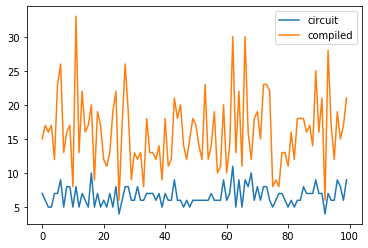

In [22]:
# Here we analyze the overhead 
depth_array = []
compiled_depth_array = []
ratio = []

for i in range(100):
    circ = utils.random_circ_generator(num_qbits=5, num_gates=15)   # randomly generate a circuit with 5 qbits and 15 gates 
    compiled_circ = simple_compiler(circ)
    
    equal = utils.circ_equal(circ, compiled_circ)
    if not equal.all():                                # make sure we are compiling properly! 
        print("FAIL @ circuit {}".format(i))
        break
    
    depth_circ = circ.depth()
    depth_comp = compiled_circ.depth()
    
    depth_array.append(depth_circ)                    # store depth 
    compiled_depth_array.append(depth_comp)                  # store new circuit depth 
    
    ratio.append(((depth_comp - depth_circ) / depth_circ) * 100)
    

print('average initial circuit depth = {} +/- {}'.format(np.mean(depth_array), np.std(depth_array)))
print('average compiled circuit depth = {} +/- {}'.format(np.mean(compiled_depth_array), np.std(compiled_depth_array)))
print('average increase in depth = {}%'.format(np.round(np.mean(ratio), decimals=2)))


plt.plot(depth_array, label='circuit')
plt.plot(compiled_depth_array, label='compiled')
plt.legend()
plt.show()

### Circuit Optimization

In this section I propose two methods for decreasing the circuit depth of our compiled circuit. First, We add a preprocessing step which will simplify the initial circuit before we compile it. Second, we realize that adjacent gates of the same type can be combined together. 

#### Step 1:
We recognize that the identity gate does not change our quantum state vector and thus it can be removed. Furthermore, repeated applications of the $CNOT$ or $Cz$ gates also leave our quantum state vector unchanged, thus we can remove these aswell. This simplifications will reduce the depth of our compiled circuit. 

$$ CNOT \circ CNOT = 
\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix} \circ 
\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix} 
= \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} $$ 

$$ Cz \circ Cz = 
\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & -1 \end{bmatrix} \circ 
\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & -1 \end{bmatrix} 
= \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} $$ 


#### Step 2:
Recall that $ Rz(\phi) $ and $ Rx(\theta) $ correspond to rotations about the z and x axis respectively. Note, rotations are additive along the same axis (i.e $ Rz(\phi_{1}) \circ Rz(\phi_{2}) = Rz(\phi_{1} + \phi_{2}) $). This gives us a way to reduce sets of adjacent rotations into a single gate operation. 


In [32]:
## Here we implement the optimized compiler: 

def compiler(circ):
    '''A quantum compiler that produces a new quantum circuit from the 
     restricted subset of available gates. '''
    
    gate_lst, num_qbits = utils.read_circ(circ)  
    
    # Preprocessing (Step1): 
    
    utils.general_replace(gate_lst, 'I', [])  # remove Identity 
    
    length = len(gate_lst)
    for index in range(length - 1):         # iterate over the lst and remove redundant Cx, Cz gates
        
        if index >= (len(gate_lst) - 1):    # by removing the repetitive Cz and Cx gates 
            break                           # we reduce the size of the list, so we need to check this edge case
    
        curr_gate_str = gate_lst[index][0]
        curr_qbit_lst = gate_lst[index][1]
        
        if curr_gate_str in ['Cx', 'Cz']:          # Check if this gate is a Cz or Cx gate
            nxt_gate_str = gate_lst[index+1][0]
            nxt_qbit_lst = gate_lst[index+1][1]
            
            if ((nxt_gate_str == curr_gate_str) and  # check that we are applying a Cz or Cx gate twice 
                (nxt_qbit_lst == curr_qbit_lst)):    # consecutively on the same control and target qbits
                
                del gate_lst[index + 1]             # remove both gates
                del gate_lst[index]
    
    
    # Compile (similar to the simple compiler): 
    
    # replace CNOT: 
    replacement_gates = [('H', utils.get_second, []), ('Cz', [], []), ('H', utils.get_second, [])] 
    utils.general_replace(gate_lst, 'Cx', replacement_gates)
    
    # replace Hadamard: 
    replacement_gates = [('Rz', [], [np.pi/2]), ('Rx', [], [np.pi/2]), ('Rz', [], [np.pi/2])]
    utils.general_replace(gate_lst, 'H', replacement_gates)
    
    # replace X: 
    replacement_gates = [('Rx', [], [np.pi])]
    utils.general_replace(gate_lst, 'X', replacement_gates)
    
    # replace Z: 
    replacement_gates = [('Rz', [], [np.pi])]
    utils.general_replace(gate_lst, 'Z', replacement_gates)
    
    # replace y: 
    replacement_gates = [('Rz', [], [-np.pi/2]), ('Rx', [], [np.pi]), ('Rz', [], [np.pi/2])]
    utils.general_replace(gate_lst, 'Y', replacement_gates)
    
    # replace Ry(theta):
    replacement_gates = [('Rz', [], [-np.pi/2]), ('Rx', [], utils.get_first), ('Rz', [], [np.pi/2])] 
    utils.general_replace(gate_lst, 'Ry', replacement_gates)
                
            
    # simplification (Step2): 
    
    index = 0 
    while(index < len(gate_lst) - 1): 
#         print('index: {}'.format(index))
        curr_gate_str = gate_lst[index][0]
        curr_qbit_lst = gate_lst[index][1]
        curr_qbit_params = gate_lst[index][2]
        
        if curr_gate_str in ['Rx', 'Rz']:          # Check if this gate is a Rz or Rx gate
            i = 1                                  # another dummy index to look at gates ahead
            while(index + i < len(gate_lst)):
#                 print('dummy: {}'.format(i))
                nxt_gate_str = gate_lst[index+i][0]
                nxt_qbit_lst = gate_lst[index+i][1]
                nxt_qbit_params = gate_lst[index+i][2]

                if ((nxt_gate_str == curr_gate_str) and  # check that we are applying a Rz or Rx gate twice 
                    (nxt_qbit_lst == curr_qbit_lst)):    # consecutively on the same control and target qbits

                    del gate_lst[index + i]             # remove both gates
                    del gate_lst[index]

                    new_gate = (curr_gate_str, curr_qbit_lst, [curr_qbit_params[0] + nxt_qbit_params[0]])
                    gate_lst.insert(index, new_gate)    # add the combined gate and
                    break                               # break current while loop 
                
                elif ((nxt_gate_str != curr_gate_str) and  # if the next gate applied to the same qbit is different 
                      (nxt_qbit_lst == curr_qbit_lst or    # i.e instead of another Rx gate we apply a Rz or a Cz to 
                       curr_qbit_lst[0] in nxt_qbit_lst)): # the same qbit then 
                    
                    index += 1  # move forward nothing left here to simplify 
                    break
                    
                else:         # the next gate is being applied to a different set of qbits 
                    i += 1    # so we can safely check the next gate in the list 
                
            index += 1
        
        else: 
            index += 1
    
            
    compiled_circ = utils.write_circ(gate_lst, num_qbits)
    
    return compiled_circ

### Bonus Step 3: 
Another potential optimization we can make is recognizing that there were multiple decompositions of the $Y$ gate, $Ry$ gate and the $H$ gate. Choosing a different decomposition for each on a case by case basis (in combination with step 2) could lead to further reduction in the depth size. Implementing this feature and exploring the potential decrease in circuit depth is left to the reader as exercise. 

$$ Y = Rx(\frac{\pi}{2}) \circ Rz(\pi) \circ Rx(-\frac{\pi}{2}) \; or \; Y = Rz(-\frac{\pi}{2}) \circ Rx(\pi) \circ Rz(\frac{\pi}{2}) $$  

$$ H = Rx(\frac{\pi}{2}) \circ Rz(\frac{\pi}{2}) \circ Rx(\frac{\pi}{2}) \; or \; H = Rz(\frac{\pi}{2}) \circ Rx(\frac{\pi}{2}) \circ Rz(\frac{\pi}{2}) $$ 

$$ R_{3y}(\lambda) = R_{3x}(\frac{\pi}{2}) \circ R_{3z}(\lambda) \circ R_{3x}(-\frac{\pi}{2}) \; or \;  R_{3y}(\lambda) = R_{3z}(-\frac{\pi}{2}) \circ R_{3x}(\lambda) \circ R_{3z}(\frac{\pi}{2}) $$

average initial circuit depth = 6.47 +/- 1.3375724279454928
average compiled circuit depth = 14.97 +/- 4.353056397521172
average optimized circuit depth = 13.32 +/- 4.093604768416219
average increase in depth from simple compiler = 133.53%
average increase in depth from optimized compiler = 107.69%


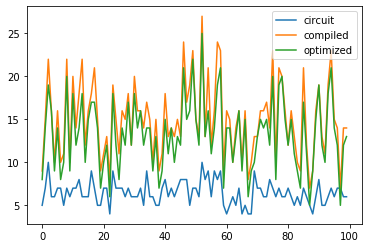

In [37]:
# Here we analyze the overhead 
depth_array = []
compiled_depth_array = []
optimized_depth_array = []
ratio_simple = []
ratio_opt = []

for i in range(100):
    circ = utils.random_circ_generator(num_qbits=5, num_gates=15)   # randomly generate a circuit with 5 qbits and 15 gates 
    compiled_circ = simple_compiler(circ)
    optimized_circ = compiler(circ)
    
    equal1 = utils.circ_equal(circ, compiled_circ)
    equal2 = utils.circ_equal(circ, optimized_circ)
    
    if not equal1.all():                                # make sure we are compiling properly! 
        print("simple compiler FAIL @ circuit {}".format(i))
        break
    
    if not equal2.all():                               
        print("optimized compiler FAIL @ circuit {}".format(i))
        break
       
    depth_circ = circ.depth()
    depth_comp = compiled_circ.depth()
    depth_opt = optimized_circ.depth()
    
    depth_array.append(depth_circ)                    # store depth 
    compiled_depth_array.append(depth_comp)           # store new circuit depth 
    optimized_depth_array.append(depth_opt)           # store optimized circuit depth
    
    ratio_simple.append(((depth_comp - depth_circ) / depth_circ) * 100)
    ratio_opt.append(((depth_opt - depth_circ) / depth_circ) * 100)
    
    

print('average initial circuit depth = {} +/- {}'.format(np.mean(depth_array), np.std(depth_array)))
print('average compiled circuit depth = {} +/- {}'.format(np.mean(compiled_depth_array), np.std(compiled_depth_array)))
print('average optimized circuit depth = {} +/- {}'.format(np.mean(optimized_depth_array), np.std(optimized_depth_array)))
print('average increase in depth from simple compiler = {}%'.format(np.round(np.mean(ratio_simple), decimals=2)))
print('average increase in depth from optimized compiler = {}%'.format(np.round(np.mean(ratio_opt), decimals=2)))

plt.plot(depth_array, label='circuit')
plt.plot(compiled_depth_array, label='compiled')
plt.plot(optimized_depth_array, label='optimized')
plt.legend()
plt.show()


We observe a 20% - 25% reduction in mean circuit depth between the simple and optimized compilers ! 

## Hardware Topology and the Qbit Routing problem

One key assumption that we have made in the construction of this compiler is assuming that each qbit could was directly connected to any other qbit. That is, we could apply $Cz$ gates between any two arbitrary qbits. Physically, this would require the qbits are connected electronically. Often times having a fully connected set of qbits is not physically possible, instead the qbits are connected in a network. This network can be represented as a graph which is called the topology of the qbits. One result of this is that we cannot apply Cz gates on two qbits unless they are 'physically' connected. (If you are interested in learning more about this problem check out this paper: https://arxiv.org/pdf/1902.08091.pdf) 

In an effort to make our simple compiler more 'realistic' below I develope a qbit router, which assumes a 5 qbit ring topology (like in the paper) and produces a properly routed quantum circuit: 

In [ ]:
## Here we develop the router: 

topology = {0:[1,4], 1:[0,2], 2:[1,3], 3:[2,4], 4:[3, 0]}  # the key is the qbit and the value is the set of connected qbits

def get_path(topology, start, end):
    path = [] 
    path.append(end)
    
    current = end
    while start not in topology[current]:
        current = topology[current][1]           # def not optimized since i am just traversing the ring clockwise 
        path.append(current)                     # instead of finding the shortest path 
    
    path.append(start)
    
    return path

def get_swaps(path): 
    replacement_gates = []
    
    for i in range(len(path) - 1):
        swap = ('S', [path[i], path[i+1]], [])
        replacement_gates.append(swap)
    
    return replacement_gates
    

def circ_router(circ, topology): 
    '''Takes a compiled circuit, and a topology to produce a 
    properly routed circuit. '''
    
    gate_lst, num_qbits = gate_lst, num_qbits = utils.read_circ(circ)
    
    for index, gate in enumerate(gate_lst): 
        curr_gate_str = gate_lst[index][0]
        curr_qbit_lst = gate_lst[index][1]
        curr_parms = gate_lst[index][2]
        
        if curr_gate_str == 'Cz':
            cntrl_qbit = curr_qbit_lst[0]
            trgt_qbit = curr_qbit_lst[1]
            
            if not trgt_qbit in topology[cntrl_qbit]:
                path = get_path(topology, cntrl_qbit, trgt_qbit)
                first_swaps = get_swaps(path)
                swap_backs = get_swaps(path.reverse())
                
                replacement = first_swaps + [(curr_gate_str, curr_qbit_lst, curr_parms)] + swap_backs
                
                del gate_lst[index]
                gate_lst.insert(index, replacement)
    
    
    compiled_circ = utils.write_circ(gate_lst, num_qbits)
    
    return compiled_circ     
        
    